In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch.nn as nn
import torchvision.models as models
import torch

In [4]:
class EncoderCnn(nn.Module):
    def __init__(self,embed_size):
        super(EncoderCnn, self).__init__()
        
        #using pretrained model 
        pretrained = models.resnet50(weights=True)
        #freezing training of weights
        for param in pretrained.parameters():
            param.requires_grad = False
            
        #getting all layers in list module and removed the last layer(we will add our own)
        modules = list(pretrained.children())[:-1]
        #putting final layers in out variable
        self.pretrained = nn.Sequential(*modules)
        
        #changing last layer and allow it to train
        self.fc = nn.Linear(pretrained.fc.in_features, embed_size)
        self.batch= nn.BatchNorm1d(embed_size,momentum = 0.01)
        self.fc.weight.data.normal_(0., 0.02)
        self.fc.bias.data.fill_(0)
        
    def forward(self,images):
        features = self.pretrained(images)
        #flattening to pass to fully connected layer
        features = features.view(features.size(0),-1)
        features = self.batch(self.fc(features))
        return features  #[batch, embed_size]
    

In [5]:
# testing
model =  EncoderCnn(6)
model.eval()
x = torch.randn(7,3,8,8)
x = model(x)
# print(model)
print(x.shape)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 151MB/s]


torch.Size([7, 6])


In [6]:
class DecoderRnn(nn.Module):
    def __init__(self, embed_size,vocab_size, hidden_size, num_layers):
        super(DecoderRnn, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size) #[batch,seq] -> [batch,seq,embed]
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers,batch_first=True) #[batch,seq,embed]->hiddens[batch,seq,hidden_size]
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, features, caption):
        embeddings = self.dropout(self.embedding(caption)) #[batch,seq] -> [batch,seq,embed]
#         print(embeddings.shape)
#         print(features.shape)
#         z = features.unsqueeze(1)
#         print(z.shape)
        embeddings = torch.cat((features.unsqueeze(1),embeddings), dim=1)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

In [7]:
# testing
model = DecoderRnn(6,10,4,2)
model.eval()
y = torch.randint(1, 10, (7,10))
print(x.shape)
model(x,y).shape

torch.Size([7, 6])


torch.Size([7, 11, 10])

In [8]:
a = torch.ones(2,2,6)
b = torch.zeros(2,6)
b=b.unsqueeze(1)
print(torch.cat((b,a),dim=1))
a,b.shape

tensor([[[0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.]]])


(tensor([[[1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1.]],
 
         [[1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1.]]]),
 torch.Size([2, 1, 6]))

In [9]:
class CNN2RNN(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size, num_layers):
        super(CNN2RNN, self).__init__()
        self.encoderCNN = EncoderCnn(embed_size)
        self.decoderRNN = DecoderRnn(embed_size, vocab_size, hidden_size, num_layers)
    
    def forward(self, images, caption):
        x = self.encoderCNN(images)
        x = self.decoderRNN(x, caption)
        return x
    
    def captionImage(self, image, vocabulary, maxlength=50):
        result_caption = []
        
        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            print(x)
            states = None
            
            for _ in range(maxlength):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
#                 print(predicted)
                result_caption.append(predicted.item())
#                 print(output.shape)
                x = self.decoderRNN.embedding(predicted).unsqueeze(0)
#                 print("x",x)
                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break
        return [vocabulary.itos[i] for i in result_caption]

In [11]:
# testing
model = CNN2RNN(6,10,4,2)
x = torch.randn(7,3,299,299)
y = torch.randint(1, 10, (7,10))
model(x,y)
model.eval()
img = torch.randn(1,3,8,8)
# model.captionImage(image = img,vocabulary=dataset.vocab)

NameError: name 'dataset' is not defined

> # Handling data

In [10]:
import os
import pandas
import spacy

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

from PIL import Image
from torchvision.transforms import transforms

In [11]:
spacy_eng = spacy.load("en_core_web_sm")

In [12]:
class Vocabulary:
    def __init__(self, freq_threshold):
        
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        
        self.freq_threshold = freq_threshold
    
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]
    
    def build_vocabulary(self,sentences):
        idx = 4
        frequency = {}
        
        for sentence in sentences:
            for word in self.tokenizer_eng(sentence):
                if word not in frequency:
                    frequency[word] = 1
                else:
                    frequency[word] += 1
                
                if (frequency[word] > self.freq_threshold-1):
                    self.itos[idx] = word
                    self.stoi[word] = idx
                    idx += 1
    
    def numericalize(self,sentence):
        tokenized_text = self.tokenizer_eng(sentence)
        
        return [self.stoi[word] if word in self.stoi else self.stoi["<UNK>"] for word in tokenized_text ]
                    
        

In [13]:
annotation = pandas.read_csv("/flickr8kimagescaptions/flickr8k/captions.txt")
annotation.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [14]:
annotation['caption'].tolist()[:2]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .']

In [15]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir="../input/flickr8kimagescaptions/flickr8k/images", caption_path="../input/flickr8kimagescaptions/flickr8k/captions.txt", freq_threshold=5, transform=None, data_length=10000):
        self.freq_threshold = freq_threshold
        self.transform = transform
        self.root_dir = root_dir
    
        self.df = pandas.read_csv(caption_path)[:data_length]
        
        self.captions = self.df['caption']
        self.images = self.df['image']
        
        self.vocab = Vocabulary(freq_threshold)
        
        print(len(self.captions.tolist()))
        self.vocab.build_vocabulary(self.captions.tolist())
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        image = self.images[index]
        
        img = Image.open(os.path.join(self.root_dir,image)).convert("RGB")
        
        if (self.transform):
            img = self.transform(img)
        
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        
        numericalized_caption += self.vocab.numericalize(caption)
        
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return img, torch.tensor(numericalized_caption)

In [16]:
# will create dataloader class and understand what is collate !!!
class MyCollate:
    def __init__(self, pad_value):
        self.pad_value = pad_value
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        img = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_value)
        
        return img, targets

In [17]:
transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

In [18]:
# will create dataloader class and understand what is collate !!!
def get_loader(root_dir="../input/flickr8kimagescaptions/flickr8k/images", caption_path="../input/flickr8kimagescaptions/flickr8k/captions.txt", transform=transform, batch_size=32, num_workers=8, shuffle=True, pin_memory=True):
    dataset = FlickrDataset(root_dir=root_dir,caption_path=caption_path, transform=transform)
    pad_value = dataset.vocab.stoi["<PAD>"]
    
    loader = DataLoader(dataset=dataset, batch_size=32, num_workers=8, shuffle=True, pin_memory=True, collate_fn=MyCollate(pad_value))
    
    return loader, dataset

In [19]:
 loader, dataset = get_loader()

10000


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [20]:
import random
import math

x, y = dataset[math.floor(random.random() * len(dataset))]
x.shape, y.shape

(torch.Size([3, 299, 299]), torch.Size([13]))

tensor([     1, 108926, 108281, 108663, 108680, 108889, 108890, 107974, 108899,
        108926, 108619, 108925,      2])
<SOS> a brown dog runs through the water on a beach . <EOS> 

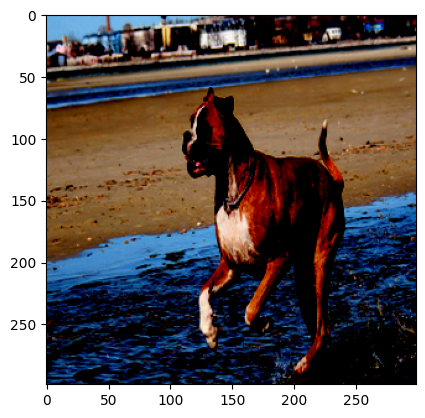

In [21]:
import matplotlib.pyplot as plt

plt.imshow(x.permute(1,2,0))
print(y)

# print(dataset.vocab.itos[1])

for i in y:
    print(dataset.vocab.itos[int(i)],end=" ")

In [22]:
def save_checkpoint(state, filename = "my_checkpoint.pth.tar"):
    print("saving checkpoint!")
    torch.save(state, filename)
    
def load_checkpoint(checkpoint, model, optimizer):
    print("loading checkpoint!")
    model.load_state_dict(checkpoint["state_dict"])
    model.load_state_optimizer(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

> #  **Training Model**

In [23]:
from tqdm import tqdm

In [25]:
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
load_model = False
save_model=False
train_CNN = False

In [26]:
print(device)

cuda


In [132]:
# import torch.optim as optim 
save_model = True
step = 0
embed_size = 256
hidden_size = 256
num_layers = 2
num_epochs = 1
learning_rate = 1e-3
vocab_size = len(dataset.vocab)

In [112]:
model = CNN2RNN(embed_size=embed_size, hidden_size=hidden_size,vocab_size=vocab_size, num_layers=num_layers).to(device=device)

In [113]:
model.decoderRNN

DecoderRnn(
  (embedding): Embedding(108931, 256)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  (linear): Linear(in_features=256, out_features=108931, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [114]:
loss_criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [116]:
if load_model:
    step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

In [133]:
model.train()

for epoch in range(num_epochs):
    if save_model:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": model.state_dict(),
            "step": step,
        }
        save_checkpoint(checkpoint)
        
    for idx, (imgs, captions) in enumerate(loader):
        imgs = imgs.to(device)
        captions = captions.to(device)
        
        score = model(imgs, captions[:,:-1])
#         print(score.shape,captions.shape)
#         print(score.reshape(-1, score.shape[2]).shape, captions.reshape(-1).shape)
#         print("why are we reshaping it here?")
        optimizer.zero_grad()
        loss = loss_criterion(score.reshape(-1, score.shape[2]), captions.reshape(-1))
        
       
        step += 1
        
        loss.backward()
        optimizer.step()
    print(f"Loss for epoch {epoch}: {loss}")

saving checkpoint!
Loss for epoch 0: 1.4267289638519287


['<SOS>', 'a', 'woman', 'who', 'is', 'ski', '-', '<UNK>', 'poses', 'for', 'the', 'camera', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
tensor([[[ 2.6426e+00,  2.1110e+00, -1.1213e-01, -2.8247e+00, -3.0133e-01,
           7.3073e-02, -9.8691e-01, -6.2137e-02, -1.3467e-01,  4.7918e-01,
           1.4078e+00, -6.6490e-01, -9.4840e-01,  2.1419e+00, -7.8010e-01,
           1.2125e+00,  7.5143e-01, -6.2580e-01, -1.3329e+00, -8.0682e-01,
           1.4231e+00, -9.5944e-01,  4.5870e-01,  9.4398e-01, -2.4049e+00,
          -1.0199e-03,  1.2043e+00,  9.7392e-03,  2.3903e+00, -9.5416e-01,
          -1.6339e+00,  5.8579e-01,  1.1940e+00, -2.4351e+00, -6.2253e-01,
           9.0871e-01,  1.4688e+00,  5.8598e-01, -3.1994e+00,  8.9879e-01,
           8.2284e-01,  1.2259e+00, -4.3237e-01,  1.6987e+00,  1.0872e-01,
          -6.1474e-01, -4.4810e-01,  2.4123e+00, -1.0153e+00, -6.0051e-01,
          -5.7669e-01, -1.2713e+00,  8.4639e-01,  1.954

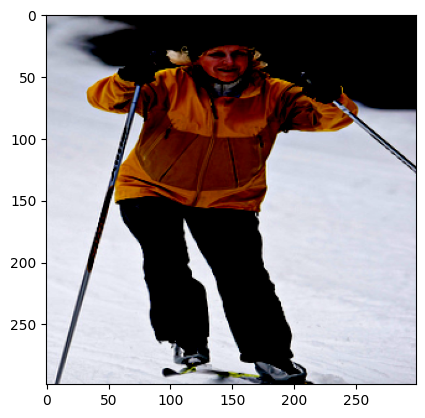

In [175]:
img,c = next(iter(loader))

n = 31
plt.imshow(img[n].permute(1,2,0))
img = img[n].unsqueeze(0).to(device)
c = c[n].unsqueeze(0).to(device)

cap = c.cpu()
cap = cap.numpy()[0]

cap = [dataset.vocab.itos[i] for i in cap]
print(cap)
model.eval()
print(model.captionImage(image=img, vocabulary=dataset.vocab))